# Building textmodels, classifiers, and explanations

In [61]:
import itertools

import pandas as pd
import numpy as np
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

from functions import *

In [2]:
# Defining constants with the journal names
SYN = "Synthese"
PS = "Philosophical Studies"
PT = "Philosophy & Technology"
ERK = "Erkenntnis"
JPL = "Journal of Philosophical Logic"
MM = "Minds and Machines"
journal_names = [SYN, PS, PT, ERK, JPL, MM]

## Exploratory data analysis

In [3]:
# Load the data
df = pd.read_csv("data/complete_abstract_data.csv")

# Set seaborne theme
sns.set_theme(style="whitegrid")

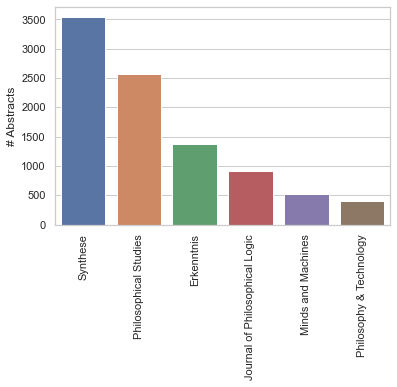

In [4]:
# Plot distribution over different journals
plt.xticks(rotation=90)
ax = sns.barplot(x="Journal", y="Abstract", data=df.groupby("Journal").count()
                 .sort_values("Abstract", ascending=False)
                 .reset_index())

ax.set(xlabel="", ylabel="# Abstracts")
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Count'>

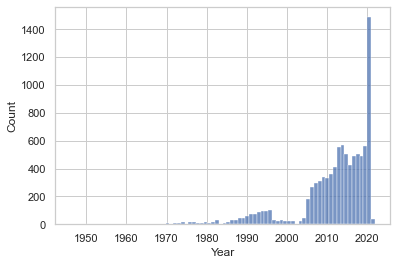

In [42]:
sns.histplot(data=df, x="Year")

The mean abstract length is 941.5264854410659, with standard deviation 419.45953809156094. 
The shortest abstract is 41 words long, the longest 5794


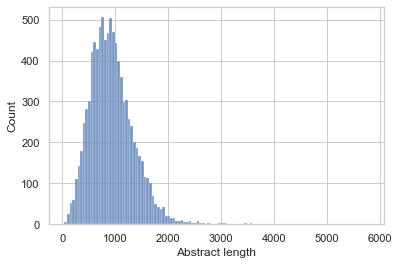

In [6]:
# Abstract length overall and for each journal
df["Abstract length"] = df["Abstract"].apply(lambda x: len(x))

# Print histogram
sns.histplot(data=df, x="Abstract length")

# Print descriptive statistics
max_len = np.max(df["Abstract length"])
min_len = np.min(df["Abstract length"])
mean_len = np.mean(df["Abstract length"])
std_len = np.std(df["Abstract length"])
print(f"The mean abstract length is {mean_len}, with standard deviation {std_len}. \nThe shortest abstract is {min_len} words long, the longest {max_len}")

In [7]:
# Initialize list to store different wordclouds
wordclouds = []

# Run through journal names
for j in journal_names:
    # Concatenate all abstract texts from this particular journal
    text = df[df["Journal"]==j]["Text"].str.cat(sep=' ')
    # Preprocess the text
    text_pp = " ".join(gensim.utils.simple_preprocess(text, min_len=3, max_len=30))
    # Generate a wordcloud
    wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text_pp)
    # Append wordcloud to list
    wordclouds.append(wordcloud)


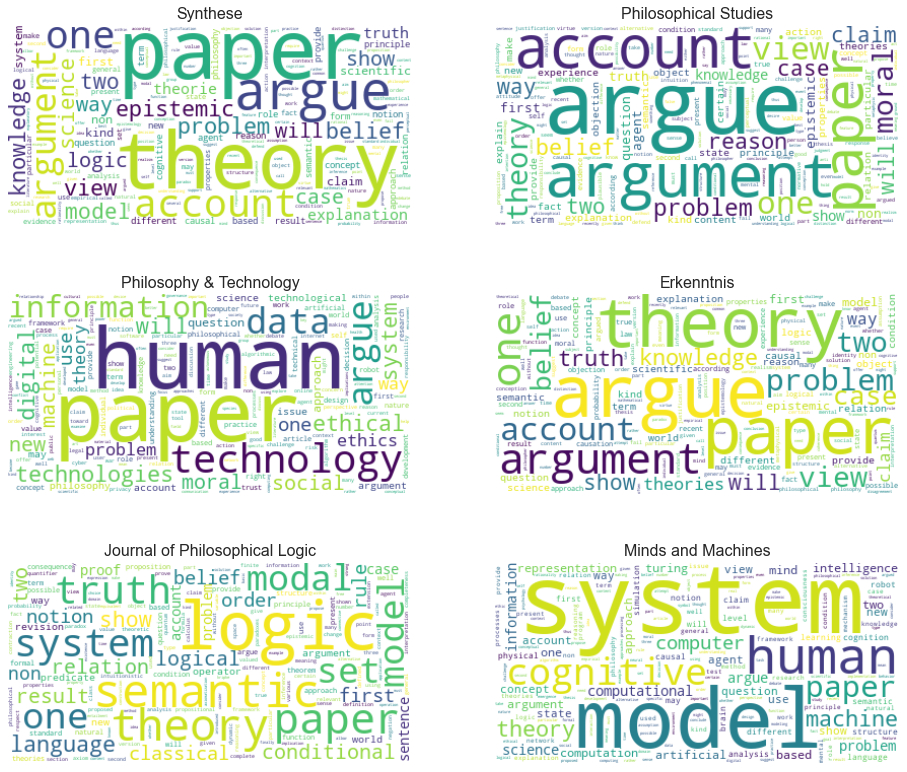

In [8]:
# Create the grid of subplots
fig, axs = plt.subplots(3,2)

# Initialize the counter
count = 0

# For each row in the grid
for i in range(3):
    # For each position in the row
    for j in range(2):
        # Plot wordcloud
        axs[i,j].imshow(wordclouds[count], interpolation='bilinear')
        # Don't show the axes
        axs[i,j].axis("off")
        # Plot the journal name as the title
        axs[i,j].set_title(journal_names[count], fontsize=16)
        # Increase the count
        count+=1
    

# Rescale the figure
fig.set_size_inches(16, 14)

The wordclouds show that each journal seems to have its distinctive topics, which influences the words that most commonly occur. This should give us confidence that we will be able to relatively reliably classify abstracts into journals.

## Building a classification pipeline

In this part, we will build a classification pipeline consisting of a textmodel and a multi-class classifier. We will use 10-fold cross validation to find the best combination of textmodel, classifier, and hyperparamteres. The textmodels we consider are doc2vec and TF-IDF. The classifiers we consider are logistic regression and XGBoost.

In [4]:
# Split in train and test data set
X_train, X_test, y_train, y_test = train_test_split(df["Text"], 
                                                    df["Journal"], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [19]:
# SMOTE to account for class imbalance #### DELETE
t_model = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)
clf = LogisticRegression(random_state=0,solver='lbfgs',C=10,max_iter=400)
smt = SMOTE(random_state=42)

pipeline = make_pipeline(t_model,smt,clf)

In [5]:
# Define a dictionary of different hyperparameters for cross validation
hyperparameters = {
    "textmodels" : ["tf_idf","doc2vec"],
    "classifier" : [{"xgb" : {"n_estimators": [500,1000], "max_depth": [5,7]}},
                    {"log": {"penalty": ["none", "l2"], "C": [100, 50, 10, 0.1]}}]
}

#### Cross validation

In [6]:
# Initialize list to store the different pipelines in
pipelines = []

# Run through different combinations of hyperparameters and generate pipelines
for textmodel in hyperparameters["textmodels"]:
    for classifier in hyperparameters["classifier"]:
        for k in classifier:
            hyperparameter_1 = list(classifier[k].values())[0]
            hyperparameter_2 = list(classifier[k].values())[1]
            # Get catesian product of hyperparameters
            for comb in itertools.product(hyperparameter_1,hyperparameter_2):
                # Set textmodel
                if textmodel=="tf_idf":
                    t_model = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)
                elif textmodel=="doc2vec":
                    t_model = DocVectorizer()
                
                # Set SMOTE object to resolve class imbalance
                smt = SMOTE(random_state=42)
                
                # Set classifier   
                if k=="xgb":
                    clf = xgb.XGBClassifier(max_depth=comb[1], objective='multi:softmax', n_estimators=comb[0], num_classes=6)
                elif k=="log":
                    clf = LogisticRegression(random_state=0,solver='lbfgs',penalty=comb[0],C=comb[1],max_iter=400)
                    
                # Make pipeline
                pipeline = make_pipeline(t_model,smt,clf)
                pipelines.append(pipeline)

In [43]:
# Define the fold
kfold = KFold(n_splits=3)

# Reset the indices of the training set so the KFold indices are consistent
X_train_reset = X_train.reset_index()["Text"]
y_train_reset = y_train.reset_index()["Journal"]

# Initialize a list to keep the scores in
scores = []

# Iterate throug pipelines
for pipeline in pipelines:
    
    # Initialize list to store scores of individual cv-folds
    scores_temp = []
    
    # Run 10-fold cross validation
    for cv_train, cv_test in kfold.split(X_train_reset):
        
        # Train model on cv_train (check whether the indices are still the old ones)
        pipeline.fit(X_train_reset[cv_train], y_train_reset[cv_train])
        # Predict for CV relative test set
        predictions = pipeline.predict(X_train_reset[cv_test])
        # Check accuracy relative to y_train (if indices are same, it should not be required to send them in the split)
        accuracy = accuracy_score(y_train_reset[cv_test], predictions)
        #f1 = f1_score(y_train_reset[cv_test], predictions)
        # Store accuracy in scores variable
        scores_temp.append(accuracy)
    
    # Append scores to list
    scores.append([pipeline, np.mean(scores_temp)])

# Store to csv
#pd.DataFrame(scores).to_csv("data/cv_smote_scores.csv")
        

#### Evaluation of the cross validation

In [13]:
# Load scores from CSV
score_df = pd.read_csv("data/cv_smote_scores.csv")[["0","1"]]
score_df = score_df.rename(columns={"0":"Pipeline", "1":"Accuracy"})
        
# Extract information from pipeline
score_df["Textmodel"] = score_df["Pipeline"].apply(lambda x: get_textmodel(x))
score_df["Classifier"] = score_df["Pipeline"].apply(lambda x: get_classifier(x))
score_df["Model"] = score_df["Textmodel"] + ", " + score_df["Classifier"] 
score_df["Hyperparameters"] = score_df["Pipeline"].apply(lambda x: get_hyperparams(x))
score_df["Full info"] = score_df["Model"]+" ("+score_df["Hyperparameters"]+")"

# Drop pipeline column
score_df = score_df.drop(columns=["Pipeline"])

# Order by performance
score_df = score_df.sort_values("Accuracy", ascending=False)

# Print 5 best performing models
score_df.head(5)

,Accuracy,Textmodel,Classifier,Model,Hyperparameters,Full info
10,0.555139,TFIDF,LogReg,"TFIDF, LogReg","C=10,max_iter=400,random_state=0","TFIDF, LogReg (C=10,max_iter=400,random_state=0)"
9,0.554601,TFIDF,LogReg,"TFIDF, LogReg","C=50,max_iter=400,random_state=0","TFIDF, LogReg (C=50,max_iter=400,random_state=0)"
8,0.554601,TFIDF,LogReg,"TFIDF, LogReg","C=100,max_iter=400,random_state=0","TFIDF, LogReg (C=100,max_iter=400,random_state=0)"
4,0.524916,TFIDF,LogReg,"TFIDF, LogReg","C=100,max_iter=400,penalty='none',random_state=0","TFIDF, LogReg (C=100,max_iter=400,penalty='non..."
5,0.524916,TFIDF,LogReg,"TFIDF, LogReg","C=50,max_iter=400,penalty='none',random_state=0","TFIDF, LogReg (C=50,max_iter=400,penalty='none..."


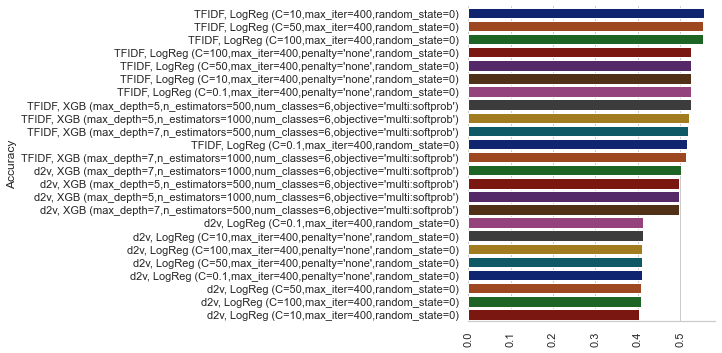

In [12]:
# Plot performances
sns.set_theme(style="whitegrid")

# Draw a horizontal barplot
g = sns.catplot(
    data=score_df, kind="bar",
    y="Full info", x="Accuracy",
    ci="sd", palette="dark", alpha=1, height=5, aspect=2, orient="h"
)

g.despine(left=True)
plt.xticks(rotation=90)
g.set_axis_labels("", "Accuracy")

We can see that the best performing model uses TF-IDF to represent the text, a logistic regression classifier with l2 regularization, where the regularization strength is set at C=10. Its accuracy is ~0.56. For a 6-class classification problem, where baseline accuracy of a random classifier is ~0.17%, this can be considered a decent level of accuracy.

Generally, we observe that TF-IDF together with logistic regression seems to work best. On the other hand, doc2vec together with logistic regression performs significantly worse than all other models, around an accuracy of 0.4.

#### Building the final model and estimating its accuracy

We now build the final model on the entire training set, rather than on a number of folds, and estimate its performance by analysing its accuracy on the test set.

In [15]:
# TF-IDF Model
t_model = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)

# Set SMOTE object to resolve class imbalance
smt = SMOTE(random_state=42)

# Logreg classifier
clf = LogisticRegression(random_state=0,solver='lbfgs',penalty='l2',C=10,max_iter=400)

# Build pipeline
pipeline = make_pipeline(t_model,smt,clf)

# Fit model
pipeline.fit(X_train, y_train)

# Predict 
predictions = pipeline.predict(X_test)

In [17]:
# Make predictions for test set
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: "+str(accuracy))

Test accuracy: 0.5547798066595059


In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = [ERK, JPL, MM, PS, PT, SYN], 
                     columns = [ERK, JPL, MM, PS, PT, SYN])

# Get counts as sanity check
cm_df['Total in test set'] = cm_df.sum(axis=1)
total = cm_df.sum(axis=0)
total.name = 'Total Predictions'

# Assign sum of all rows of DataFrame as a new Row
cm_df = cm_df.append(total.transpose())

In [20]:
# Show confusion matrix
cm_df[]

,Erkenntnis,Journal of Philosophical Logic,Minds and Machines,Philosophical Studies,Philosophy & Technology,Synthese,Total in test set
Erkenntnis,66,17,4,75,1,117,280
Journal of Philosophical Logic,10,130,0,6,0,43,189
Minds and Machines,8,0,52,4,16,23,103
Philosophical Studies,47,11,3,300,2,146,509
Philosophy & Technology,2,0,13,2,54,9,80
Synthese,66,51,26,123,4,431,701
Total Predictions,199,209,98,510,77,769,1862


In [44]:
# Initialize list for true positives
tps = []

# Get true positives for each journal
for i in range(6):
    tps.append(cm_df.iloc[i,i])
    
# Positive predictive values / precision
ppvs = tps/cm_df.loc["Total Predictions"][:6]

# True positive rates / sensitivity
tprs = tps/cm_df["Total in test set"][:6]

print("Positive predictive values / precision:")
print(ppvs)
print("\n")
print("True positive rates /sensitivity:")
print(tprs)

Positive predictive values / precision:
Erkenntnis                        0.331658
Journal of Philosophical Logic    0.622010
Minds and Machines                0.530612
Philosophical Studies             0.588235
Philosophy & Technology           0.701299
Synthese                          0.560468
Name: Total Predictions, dtype: float64


True positive rates /sensitivity:
Erkenntnis                        0.235714
Journal of Philosophical Logic    0.687831
Minds and Machines                0.504854
Philosophical Studies             0.589391
Philosophy & Technology           0.675000
Synthese                          0.614836
Name: Total in test set, dtype: float64


Looking at individual positive predictive values and true positive rates, we see that predictions are relatively good for Philosophy & Technology (0.70/0.68) and Journal of Philosophical Logic (0.62/0.69). This might be due to the fact that the subject matter of these journals is more specific than the others. Erkenntnis and Synthese are more similar in topics, so it is understandable that some abstracts are mistakenly classified as belonging to one of the other journals. Erkenntnis stands out as its values are the worst among the six journals with 0.33/0.24. This is because most of the Erkenntnis abstracts were classfied as belonging to Synthese. For all other journals the values are decent.

## Making classifications explainable

In this part, we will use the LIME explainability framework to generate explanations for individual classifications. 

In [63]:
# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=[ERK, JPL, MM, PS, PT, SYN])

In [112]:
# True: 6489, 274, 4031, 3399, 4639
k = 3399

# Print predictions and true values
print("Predicted: "+pipeline.predict(X_test[k]))
print("True: "+y_test[k])

['Predicted: Synthese']
True: Synthese


In [113]:
# Generate explanation
explanation = explainer.explain_instance(X_test[k], pipeline.predict_proba, top_labels=1)
explanation.show_in_notebook()

## Finding most similar abstracts 

In this part, we will train a doc2vec document vector embedding to allow for sensible similarity comparisons between abstracts. This will add to the transparency of the classification in that it allows a user to evaluate the quality of the classification based on the journals similar articles have been published in.